In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from bokeh.layouts import column,row,layout
from bokeh.models import ColumnDataSource, Slider, RadioButtonGroup,TableColumn, DataTable, Range1d, LinearAxis
from bokeh.plotting import figure, output_file, show
from bokeh.themes import Theme
from bokeh.io import show, output_notebook, output_file, push_notebook
from bokeh.layouts import widgetbox
from bokeh.models.tools import HoverTool, PointDrawTool
#прочие
import pandas as pd
import numpy as np
from scipy import special
import os
import scipy as sp
import matplotlib.pyplot as plt
import pylab


output_notebook()

Loading BokehJS ...

In [3]:
pi=math.pi
g=9.81

In [4]:
#Fourier's law
def q_conduction(l,k,r0,ri,t0,ti):
    return 2*pi*k*(t0-ti)/np.log(r0/ri)
#Newton's law
def q_convection(ri,l,h,tf,ti):
    '''ri - pipe inside radius (m),
    l - pipe lenth (m)
    h - constant of proportionality called 'convective heat transfer
    coefficient (W/m2/C)'
    tf - fluid temperature (C)
    ti - inner wall temperature (C)
    
    '''
    return 2*pi*ri*l*h*(tf-ti)

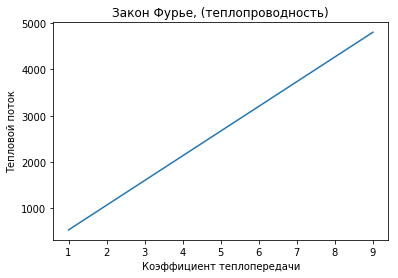

In [5]:
x=np.asarray(range(1,10))
y=q_conduction(10,x,0.9,0.8,20,10)
plt.plot(x,y)
plt.title('Закон Фурье, (теплопроводность)')
plt.xlabel('Коэффициент теплопередачи')
plt.ylabel('Тепловой поток')
plt.show()   



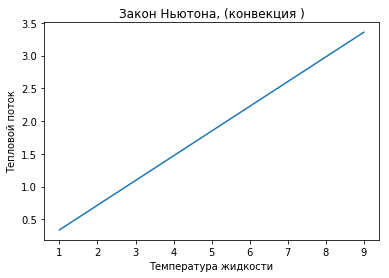

In [6]:
x=np.asarray(range(1,10))
y=q_convection(0.06,1,1,x,0.1)
plt.plot(x,y)
plt.title('Закон Ньютона, (конвекция )')
plt.xlabel('Температура жидкости')
plt.ylabel('Тепловой поток')
plt.show()   

## Исходные данные

In [7]:
depth_m=2560  #глубина скважины
rto_m=73/2/1000 #внешний радиус НКТ
rti_m=61/2/1000 #внутренний радиус НКТ
rcasi_m=120/2/1000 #внутренний радиус ОК
rcaso_m=143/2/1000 #внешний радиус ОК
rwb_m=300/2/1000 #внешний радиус скважины (после цемента)

teibh_c=80 #начальная пластовая температура на забое

geoterm_gradm=0.03 #геотермический градиент, С/м


ke_dsmc=2.4 #Теплопроводность породы, Дж/сек/м/С
kcem_dsmc=4 #Теплопроводность цемента, Дж/сек/м/С
kt_dsmc=30 #Теплопроводность металла, Дж/сек/м/С
kaliq_dsmc=200 #conductivity of annular fluid, ???
#Теплопередача за счет конвекции через жидкость Дж/сек/м2/С ???
kagas_dsmc=20 #Теплопередача за счет конвекции через газ Дж/сек/м2/С ???

rho_env_kgm3=4000 #плотность горных пород, кг/м3

rho_oil_kgm3=860
rho_water_kgm3=1000
cp_oil=2100 #теплоемкость нефти, Дж/кг/С
cp_water=4100 #теплоемкость воды, Дж/кг/С
cp_env=200 #теплоемкость горных пород, Дж/кг/С

qoil_m3day=60





In [8]:
dh=np.asarray(range(0,depth_m,10)) #Массив глубины по стволу скважины
tei=(dh[-1]-dh)*geoterm_gradm*(-1)+teibh_c #Температура пласта по стволу в нач.усл.

## Функции

In [109]:
def td(t,ke=ke_dsmc,rhoe=rho_env_kgm3,cp_env=cp_env,rwb_m=rwb_m): #безразмерное время
    result=ke*t/(rhoe*cp_env*(math.pow(rwb_m,2)))
    return result
def rd(r): #безразмерное расстояние
    result=r/rwb_m
    return result
def Td(td): #безразмерная температура
    return math.log(math.exp(-0.2*td)+(1.5-0.3719*math.exp(-td))*math.sqrt(td))

def Lr(uto,w,td): #relaxation lenth parameter, 
    return 2*pi*rto_m*uto*ke_dsmc/(cp_env*w)/(ke_dsmc+rto_m*uto*td)
def reversed_uto(hto,hc,hr): #обратный коэффициет теплопередачи  ???
    first_part=rto_m/rti_m/hto #теплоотдача от ж к внутренней стенки НКТ
    second_part=rto_m*math.log(rto_m/rti_m)/kt_dsmc #теплопередача через стенку НКТ
    third_part=0
    fourth_part=rto_m/rto_m/(hc+hr) #теплоотдача от стенки НКТ ???
    fifth_part=rto_m*math.log(rcaso_m/rcasi_m)/kt_dsmc #теплопередача через стенку ОК 
    sixth_part=rto_m*math.log(rwb_m/rcaso_m)/kcem_dsmc #теплопередача через цементное кольцо
    return first_part+second_part+third_part+fourth_part+fifth_part+sixth_part
def w(q,rho): # массовый расход, кг/сек
    return q/86400*rho
def number_gr(rho,betta,delta_t,d,mu): #число Грасгофа
    return rho**2*betta*g*delta_t*d**3/mu**2
def number_pr(cp,mu,k): #число Прандтля
    return cp*mu/k
def number_nu(h,d,k): #число Нуссельта
    return h*d/k
def number_re(rho,v,d,mu): #число Рейнольдса
    return rho*v*d/mu
def number_nu_corr(n_re,n_pr): #корреляция для определения числа Нуссельта
    return 0.023*n_re**0.8*n_pr**0.3

def uto(hf,han,tempd,rti_m,rto_m,rcaso_m,rcasi_m,rwb_m,ke_dsmc,kcem_dsmc,kt_dsmc): #общий коэффициет теплопередачи
    first_part=1/rti_m/hf #теплоотдача от ж к внутренней стенки НКТ
    #out('first_part',first_part)
    second_part=math.log(rto_m/rti_m)/kt_dsmc #теплопередача через стенку НКТ
    #out('second_part',second_part)
    third_part=1/rcasi_m/han # конвекция через затруб
    #out('third_part',third_part)
    fourth_part=math.log(rcaso_m/rcasi_m)/kt_dsmc #теплопередача через стенку ОК 
    #out('fourth_part',fourth_part)
    fifth_part=math.log(rwb_m/rcaso_m)/kcem_dsmc #теплопередача через цементное кольцо
    #out('fifth_part',fifth_part)
    sixth_part=tempd/ke_dsmc #теплопередача через цементное кольцо
    #out('sixth_part',sixth_part)
    return 1/(first_part+second_part+third_part+fourth_part+fifth_part+sixth_part)/rto_m
def out(a,b,c=''):
    print(str(a) + ' = ' + str(b)+' --'+str(c) )

def tempd(td): #f(t)
    if td<=1.5:
        return 1.1281*math.sqrt(td)*(1-0.3*math.sqrt(td))
    elif td>1.5:
        return (0.4063+1/2*math.log(td))*(1+0.6/td)
    
def hf(ql,qg,rhol,rhog,mul,mug,kl,kg,cpl,cpg,d=rti_m*2):
    ap=pi/4*d**2
    vsl=ql/ap
    vsg=qg/ap
    vm=vsl+vsg
    llambda=vsl/vm
    rhon=rhol*llambda+rhog*(1-llambda)
    mun=mul*llambda+mug*(1-llambda)
    kn=kl*llambda+kg*(1-llambda)
    cpn=(cpl*rhol*llambda+cpg*rhog*(1-llambda))/rhon
    nren=number_re(rhon,vm,d,mun)
    nprn=number_pr(cpn,mun,kn)
    nnu=number_nu_corr(nren,nprn)
    return nnu*kn/d

def han(muan,cpan,kan,tto,tci,rhoan,betta,rci,rto):
    npr=number_pr(cpan,muan,kan)
    ngr=number_gr(rhoan,betta,(tto-tci),(rci-rto),muan)
    han=0.049*(ngr*npr)**(1/3)*npr**0.074*kan/(rto*math.log(rci/rto))
    han=0.25*han
    return han
    

def fc(pwh,mt,rp,gamma_api,gamma_gas,gg): #???????
    return ((-2.978)*10**(-3)+1.006*10**(-6)*pwh+1.906*10**(-4)*mt-1.047*10**(-6)*rp+
            3.229*10**(-5)*gamma_api+4.009*10**(-3)*gamma_gas-0.3551*gg)
def func(qg,ql,rhon,vm,at,cpm,u,dto,fc,tei,gg,l):
    rp=qg/ql
    mt=rhon*vm*at
    a=mt*cpm/pi/dto/u
    return (tei-gg*l)+a*(1-math.exp(-l/a))*(gg-g/cpm+fc)
    

In [111]:
#td(t,ke=ke_dsmc,rhoe=rho_env_kgm3,cp_env=cp_env)
val_td=td(2*7*24*3600,2.42,2504,1256,0.1079)
out('Dimensionless time',val_td,'безразмерное время')
val_tempd=tempd(val_td)
out('Dimensionless temperature',val_tempd,'безразмерная температура (f(t))')
val_hf=hf(79.5/86400,283/86400,882.9,80.3,0.015,1.5*10**(-4),0.138,1.73*10**(-4),2512,2093,0.0259*2)
out('hf, коэффициент теплоотдачи от ж к стенки НКТ',val_hf,'от жидкости к стенке НКТ')
val_han=han(0.0001,1004.81,0.865,6,3,36.92,0.004824,0.0797,0.0561)
out('han, коэффициент теплоотдачи в затрубном пространстве',val_han,'от жидкости к стенке НКТ')
rti_m=0.0259
rto_m=0.0561
rcaso_m=0.0889
rcasi_m=0.0797
rwb_m=0.108
kcem_dsmc=0.779
kt_dsmc=25
ke_dsmc=2.422
val_uto=uto(val_hf,val_han,val_tempd,rti_m,rto_m,rcaso_m,rcasi_m,rwb_m,ke_dsmc,kcem_dsmc,kt_dsmc)
out('U, общий коэффициент теплопередачи',val_uto,'с итерациями')
pwh=115
mt=2.37
rp=20
gamma_gas=0.65
gg=0.015
gamma_api=29
val_fc=fc(pwh,mt,rp,gamma_api,gamma_gas,gg)/1.8/0.3048
out('F(c)',val_fc,'корреляция')
ql=79.5
qg=283
tei=93.3
l=1000
gg=0.027
#def func(qg,ql,rhon,vm,at,cpm,u,dto,u,fc,tei,gg,l)
val_func= func(qg/86400,ql/86400,256.2,1.99,0.00211,2409.6,0.0561*2,val_uto,val_fc,tei,gg,l)
out('tf',val_func,'температура на устье')

Dimensionless time = 79.94481297101623 --безразмерное время
Dimensionless temperature = 2.6164589869053594 --безразмерная температура (f(t))
hf, коэффициент теплоотдачи от ж к стенки НКТ = 93.6571017668145 --от жидкости к стенке НКТ
han, коэффициент теплоотдачи в затрубном пространстве = 14.180994340762789 --от жидкости к стенке НКТ
U, общий коэффициент теплопередачи = 6.695118154576248 --с итерациями
F(c) = -0.00768403324584427 --корреляция
tf = 76.30741415855286 --температура на устье


In [126]:
a=-0.00421
aa=a/1.8/0.3048
print(out('kl;',a))
#tf=func(qg/86400,ql/86400,256.2,1.99,0.00211,2409.6,0.0561*2,val_uto,val_fc,tei,gg,l)
tff=[]
tfg=[]
for i in range(0,depth_m,10):
    tf=func(qg/86400,ql/86400,256.2,1.99,0.00211,2409.6,0.0561*2,val_uto,val_fc,tei,gg,i)
    tff.append(tf)
    tg=tei-gg*i
    tfg.append(tg)
l=list(range(0,depth_m,10))
#print(tff)

kl; = -0.00421 --
None


In [129]:
plot = figure(title='Распределение температуры',
               x_axis_label='Tемпература, °C',
               y_axis_label='Абсолютная глубина (TVD),м',
              y_range=(dh[-1],dh[0]),
              
            )
plot.line(tei,dh,legend='Геотерма')
show(plot)               

In [133]:

plot = figure(title='Распределение температуры',
               x_axis_label='Tемпература, °C',
               y_axis_label='Абсолютная глубина (TVD),м',
              
              
            )
#plot.line(tei,dh,legend='Геотерма')
plot.line(tff,l,color='red',legend='Температура флюида')
plot.line(tfg,l,legend='Геотерма')
show(plot)               